# The descendants view

The descendants view allows to explore the development of individual cells and their progeny (offspring) at different spatial locations of the microscopy time-lapse. We interconnect segmentation overlay visualizations on microscope images with the temporal development of selected population sizes (area & and count) to give an in-depth view into the development live-cell populations.

Have fun 🚀 executing the notebook yourself, experience the freedom of customization in jupyter notebooks, and have a look at the video below 👇


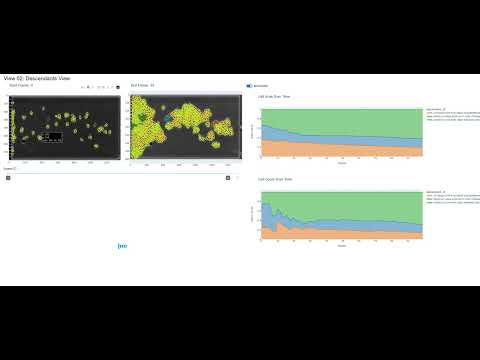

In [13]:
from IPython.display import YouTubeVideo

YouTubeVideo('KZP5OoHpMVw', width=800, height=300)

## 1. Install dependencies

In [ ]:
!pip install imagecodecs==2023.9.18 igraph==0.11.3 dash[diskcache]==2.14.1 dash-bootstrap-components==1.5.0 multiprocess==0.70.15 "git+https://jugit.fz-juelich.de/publications/acia-pre.git@c989af4c3007882239dd724a2f3a8b13715d0c88#acia" moviepy==1.0.3 ipywidgets==8.1.1

## 2. Load segmentation and tracking information

In [ ]:
# download data
!wget -O data.zip https://fz-juelich.sciebo.de/s/NjW5Dow7cW6NBlV/download

!mkdir data
!unzip -o data.zip -d data
!mkdir assets

In [ ]:
# Meta-information

pixel_size = 0.072 # micrometer/pixel
frame_step = 15/60 # 1 frame/ 15 minutes

image_path = "data/02/image_stack.tiff"
seg_and_track_file = "data/02/simpleTracking.json"

In [ ]:
from acia.tracking.formats import parse_simple_tracking
import pandas as pd

with open(seg_and_track_file, "r") as tf:
    ov, tracking_graph = parse_simple_tracking(tf.read())

cell_df = pd.DataFrame([{"id": cont.id, "area": cont.area, "frame": cont.frame, "contour_coordinates": cont.coordinates} for cont in ov])

In [ ]:
# clean up tracking

ids = set([cont.id for cont in ov])
tr_nodes = set(tracking_graph.nodes)

nodes_to_remove = tr_nodes.difference(ids)
for n in nodes_to_remove:
    tracking_graph.remove_node(n)

In [ ]:
from tqdm.auto import tqdm
import tifffile
# cache the images for faster computation
images = tifffile.imread(image_path)#[frame.raw for frame in tqdm(source, desc="Cache image")]

In [ ]:
from acia.tracking.utils import life_cycle_lineage

lc_lineage = life_cycle_lineage(tracking_graph)
lc_lookup = {det_id: cycle_id for cycle_id in lc_lineage.nodes() for det_id in lc_lineage.nodes[cycle_id]["cycle"]}

## 3. Utility functions

In [ ]:
from acia.base import Overlay
import numpy as np

def get_frame_overlay(frame: int):
    """
    # frame for every contour
    frame_information = np.array(
        list(map(lambda cont: cont.frame, ov.contours)), dtype=np.int64
    )
    # numpy array of contours (dtype=np.object)
    contour_array = np.array(ov.contours)
    
    return Overlay(list(contour_array[frame_information==frame]))
    """
    # operate on the dataframe
    return cell_df[cell_df["frame"] == frame] 

In [ ]:
import logging

def get_image_figure(frame:int, selection=None, selection_color=None):
    image = images[frame]#[...,1]
    # binary_string for compression
    compression_level=8
    fig = px.imshow(image, binary_string=True, binary_compression_level=compression_level)

    if selection is not None:
        selection = set(selection)
    
    fig.update_layout(autosize=True)


    frame_df = get_frame_overlay(frame)
    
    # loop over all contours in this frame
    for _,contour in frame_df.iterrows():

        coordinates = np.concatenate([contour["contour_coordinates"], contour["contour_coordinates"][0:1]])
        x_array = np.array(coordinates[:,0])
        y_array = np.array(coordinates[:,1])

        color = (255,255,0)
        if selection is not None:
            if contour.id in selection_color:
                color = selection_color[contour.id]
            elif contour.id in selection:
                logging.warning("color not in selection map")
                color = (255, 0, 0)

                # Adding a trace with a fill, setting opacity to 0
        fig.add_trace(
            go.Scatter(
                x=x_array, 
                y=y_array, 
                fill="toself",
                fillcolor=f'rgba{tuple([*color, 0.0])}',#'rgba(255,255,0,0.5)',
                mode='lines',
                line=dict(
                    color=f"rgb{color}",
                    width=2
                ),
                name=f'{contour.id}',
                text=f'I am cell {contour.id}',
                #opacity=0.2,
            )
        )
    
    return fig

In [ ]:
from tqdm.auto import tqdm
import dash
import uuid
import cv2
import moviepy.editor as mpy


def render_video(start_frame: int, end_frame: int, color_selection=None):
    
    if color_selection is None:
        color_selection = {}
    
    uid = uuid.uuid4()
    thickness = 2

    video_images = []
    for frame in tqdm(range(start_frame, end_frame + 1)):
        frame_image = np.copy(images[frame])#source.get_frame(frame).raw
        
        font = cv2.FONT_HERSHEY_SIMPLEX 

        # org 
        org = (50, 50) 

        # fontScale 
        fontScale = 0.5

        # Blue color in RGB 
        color = (255, 255, 255) 

        # Line thickness of 2 px 
        thickness = 2
        
        cv2.putText(frame_image, f"Frame {frame:02d}", org, font,  
                   fontScale, color, thickness, cv2.LINE_AA)
        
        frame_df = cell_df[cell_df["frame"] == frame].set_index("id")

        for cell_id, cell_data in frame_df.iterrows():
            if cell_id in color_selection:
                color = tuple(color_selection[cell_id])
            else:
                color = (255, 255, 0)

            color = tuple(map(int, color)) # otherwise cv2 complains about datatypes
            cv2.polylines(frame_image, [np.array(cell_data["contour_coordinates"]).astype(np.int32)], True, color, thickness)

        video_images.append(frame_image)
        
    clip =  mpy.ImageSequenceClip(video_images, fps=10)
    crf=23
    filename=f"assets/test-{uid}.mp4"
    clip.write_videofile(
            filename, 
            codec='vp9',ffmpeg_params=["-quality", "realtime", "-speed", "4"] # preset="ultrafast", ffmpeg_params=["-crf", str(crf)],
    )

    return dash.get_asset_url(f'test-{uid}.mp4')


## 4. Create the Visualization

In [ ]:
from IPython.display import Video, Markdown, display
import dash_bootstrap_components as dbc

import plotly.graph_objects as go
import plotly.express as px

import plotly.io as pio
import plotly.express as px
import matplotlib

from dash.long_callback import DiskcacheLongCallbackManager

## Diskcache
import diskcache
cache = diskcache.Cache("./cache")
long_callback_manager = DiskcacheLongCallbackManager(cache)


from dash import Dash, dcc, html, Input, Output, callback, no_update, State, ctx
import os
import json

from PIL import Image
from pandas import DataFrame
import networkx as nx

min_frame = 0
max_frame = len(images) - 1

app = Dash(external_stylesheets=[dbc.themes.BOOTSTRAP, dbc.icons.BOOTSTRAP])
app.layout = html.Div([
    dcc.Store(id='memory'),
    dbc.Row([
        dbc.Col([
            dbc.Row([
                dbc.Col(dcc.Loading(html.Div([
                    #html.H1("Start image"),
                    dcc.Graph(id="start-image")
                ])), width=12, lg=6),
                dbc.Col(dcc.Loading(dcc.Graph(id="target-image")), width=12, lg=6),
            ]),
            dbc.Row([
                dbc.Label(html.Span(["Frame: ", html.I(className="bi bi-info-circle", title="Use the frame slider to select your start and end frames. The graphics will update accordingly!")]), html_for="frame-slider"),
                
                dbc.Col(dcc.RangeSlider(min_frame, max_frame, step=1, value=[0, 95], id='frame-slider', allowCross=False, tooltip={"placement": "bottom", "always_visible": True}, marks={0: '0', max_frame: f'{max_frame}'},), width=12),
                dbc.Col(dcc.Loading(html.Div(id="video")), width={"size": 6, "offset": 3},),

            ]),
        ], width=6),
        dbc.Col([
            dbc.Row([
                dbc.Checklist(
                    options=[
                        {"label": "Normalize", "value": "normalize"},
                    ],
                    value=["normalize"],
                    id="normalized-input",
                    switch=True,
                ),
            ]),
            dbc.Row(dcc.Loading(dcc.Graph(id="start-area-ratio"))),
            dbc.Row(dcc.Loading(dcc.Graph(id="start-count-ratio")))
        ], width=6),

    ]),
    dbc.Row([
        dbc.Col([html.Div()],width=10),
        dbc.Col([dcc.Loading(html.Div(id="single-cell-image"))], width=2),
    ]),
], className='mh-100', style={"height": "450px"})

cmap = matplotlib.cm.get_cmap('tab10')
colors = {i: cmap(i /9) for i in range(11)}

print("Colors", colors)

@app.callback(
    Output("memory", "data"),
    Output("start-image", "figure"),
    Output("target-image", "figure"),
    Output("start-area-ratio", "figure"),
    Output("start-count-ratio", "figure"),
    Input("start-image", "clickData"),
    Input("target-image", "clickData"),
    Input("frame-slider", "value"),
    Input("normalized-input", "value"),
    State("memory", "data")
)
def update_figures(start_click, target_click, frame_slider, normalized_input, data):
    trigger_id = ctx.triggered_id
    print(trigger_id)
    print(frame_slider)
    print(start_click)
    
    if data is None:
        data = {}
        data["start_selection"] = [] #["7b7f8344-255c-4a63-91b9-ed2feaae695c", "c084d07c-57cf-4681-99c0-640abf4c7b00", "3eff078c-5c09-455f-a4e7-d71c3d9a8fb7", "08bea65f-b6b3-458b-8d93-f0c1b541834e"]
    
    start_frame = frame_slider[0]
    target_frame = frame_slider[1]
    
    #######################
    # Handle user actions #
    #######################
    
    # check whether you have clicked on the start image
    if trigger_id == "start-image" and start_click is not None:
        # curveNumber is starting at 1
        
        curveNumber = start_click["points"][0]["curveNumber"]
        
        if curveNumber != 0:
            cell_frame_index = curveNumber - 1
            frame_ov = get_frame_overlay(start_frame)
            cell_id = frame_ov.reset_index().iloc[cell_frame_index]["id"]
            selection = set(data["start_selection"])
            if cell_id in selection:
                selection.remove(cell_id)
            else:
                selection.add(cell_id)
            data["start_selection"] = list(selection)
            
    # check whether you have clicked on the target_image
    if trigger_id == "target-image" and target_click is not None:
        
        curveNumber = target_click["points"][0]["curveNumber"]
        
        if curveNumber != 0:
            cell_frame_index = curveNumber - 1
            frame_ov = get_frame_overlay(target_frame)
            cell_id = frame_ov.reset_index().iloc[cell_frame_index]["id"]
            
            # compute ancestors and intersect with start frame cells
            anc = nx.ancestors(tracking_graph, cell_id)
            start_ov = get_frame_overlay(start_frame)
            start_ids = set([cont.id for cont in start_ov])
            
            sel_anc = start_ids.intersection(anc)
            print(f"{sel_anc=}")
            
            # update selection
            if len(sel_anc) == 1:
                cell_id = list(sel_anc)[0]
                selection = set(data["start_selection"])
                if cell_id in selection:
                    selection.remove(cell_id)
                else:
                    selection.add(cell_id)
                data["start_selection"] = list(selection)
    
    # check whether the frame-slider has changed
    if trigger_id == "frame-slider":
        selection = set(data["start_selection"])
        
        # update the selections accordingly
        total = set()
        for id in selection:
            total = total.union(set(nx.ancestors(tracking_graph, id)).union(set(nx.descendants(tracking_graph, id))).union([id]))
        
        # compute the selection
        start_ov = get_frame_overlay(start_frame)
        start_ids = set([cont.id for cont in start_ov])
        selection = total.intersection(start_ids)
        data["start_selection"] = list(selection)

    ########################
    # Update cell coloring #
    ########################
            
    target_selection = set()
    target_selection_color = {}
    
    cmap = matplotlib.cm.get_cmap('tab10')
    
    cell_df_local = cell_df.copy()
    cell_df_local["color"] = "rgb(255, 255, 0)" # default color yellow
    cell_df_local["descendent_of"] = "Not selected"
    cell_df_local = cell_df_local.set_index("id")
    
    for i, selected_cell in enumerate(data["start_selection"]):
        local_target_selection = set(nx.descendants(tracking_graph, selected_cell)).union([selected_cell])
        color = tuple((np.array(colors[i % len(colors)][:3]) * 255).astype(int)) #(255, 0, 0) # set rgb color
        cell_df_local.loc[list(local_target_selection), "color"] = f"rgb({color[0]}, {color[1]}, {color[2]})"
        cell_df_local.loc[list(local_target_selection), "descendent_of"] = f"{selected_cell}"

        for cell_id in local_target_selection:
            target_selection_color[cell_id] = color

        target_selection = target_selection.union(local_target_selection)
        
    cell_df_local = cell_df_local.copy()
    
    #################
    # Render images #
    #################
        
    # draw the image
    start_image_fig = get_image_figure(start_frame, selection=data["start_selection"], selection_color=target_selection_color)
    end_image_fig = get_image_figure(target_frame, selection=target_selection, selection_color=target_selection_color)
    
    start_image_fig.update_layout(
        #height=700,
        showlegend=False,
        title=f"Start Frame: {start_frame}",
        margin=dict(
            l=0,
            r=0,
            b=0,
            t=30,
            pad=4
        ),
    )
    end_image_fig.update_layout(
        #height=700,
        showlegend=False,
        title=f"End Frame: {target_frame}",
        margin=dict(
            l=0,
            r=0,
            b=0,
            t=30,
            pad=4
        ),
    )
    
    #######################################
    # Create figures for single-cell data #
    #######################################
    

    selection = cell_df_local.copy() #cell_df_local[(cell_df_local["frame"] >= start_frame) & (cell_df_local["frame"] <= target_frame)] #pd.merge(sel_df, cell_df, how="left", on="id")
    
    selection = selection[selection["descendent_of"] != "Not selected"]
    
    df_area = selection.groupby(["frame", "descendent_of"])["area"].agg("sum").reset_index()
    df_count = selection.groupby(["frame", "descendent_of"]).size().reset_index(name="count")
        
    grouped = df_area.groupby("frame")
    df_area['area_norm'] = grouped['area'].transform(lambda x: x/x.sum())
    
    grouped = df_count.groupby("frame")
    df_count['count_norm'] = grouped['count'].transform(lambda x: x/x.sum())
    
    color_discrete_map={ancestor: selection.loc[ancestor]["color"] for i, ancestor in enumerate(np.unique(selection["descendent_of"]))}
    color_discrete_map["Not selected"] = "rgb(255, 255, 0)"
    
    y_post = ""
    if "normalize" in normalized_input:
        y_post = "_norm"
    
    area_over_time_fig = px.area(df_area, x="frame", y="area" + y_post, title="Cell Area Over Time", color="descendent_of", color_discrete_map=color_discrete_map)#, color="color", title="Cell Area Over Time"),
    count_over_time_fig = px.area(df_count, x="frame", y="count" + y_post, title="Cell Count Over Time", color="descendent_of", color_discrete_map=color_discrete_map)#, color="color", title="Cell Area Over Time"),

    # update formatting
    for figure in [area_over_time_fig, count_over_time_fig]:
        figure.update_layout(
            xaxis=dict(
                spikemode  = 'across+toaxis', spikedash = 'solid'
            ),
            autosize=True
        )

        figure.update_traces(hovertemplate=None)
        figure.update_layout(hovermode="x")
        
    return data, start_image_fig, end_image_fig, area_over_time_fig, count_over_time_fig #, area_ratio_fig, ratio_fig
    
@app.callback(
    Output("video", "children"),
    Input("memory", "data"),
    Input("frame-slider", "value"),
    #prevent_initial_call=True,
    manager=long_callback_manager,
)
def renderVideo(state, frame_slider):
    
    if state is None:
        start_selection = {}
    else:
        start_selection = state["start_selection"]
        
    target_selection_color = {}
        
    for i, selected_cell in enumerate(start_selection):
        local_target_selection = set(nx.descendants(tracking_graph, selected_cell)).union([selected_cell])
        for cell_id in local_target_selection:
            color = tuple((np.array(cmap(i / 9)[:3]) * 255).astype(int)) #(255, 0, 0) # set rgb color
            target_selection_color[cell_id] = color
    
    print("Render video...")
   
    start_frame = frame_slider[0]
    end_frame = frame_slider[1]

    # render video into file
    file = render_video(start_frame, end_frame, target_selection_color)
    
    # return video
    return html.Video(src=file, controls = True, style={"width": "100%", "height": "60vh"})

display(Markdown("# View 02: Descendants View"))
app.run_server(port=8051, jupyter_mode="inline", jupyter_height=1200)